In [7]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 2)

coeffs = [-0.5]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [8]:
Paras_global, Phi_global = np_.zeros(3), 0

In [9]:
@qml.qnode(dev)
def circuit(phi):
    """ Include the entangler stage and the phase accumulator stage for a 2-qubit system.
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2] as a paramters.
        Set 'phi' from the 'Cost_function' using global variables.
        Dephase_factors = fixed as Tau_global.

    Returns:
        qml.density_matrix: Density matrix of qnode
    """
    
    # Call global
    global Paras_global

    # Assign paras
    theta_init, tau_1, tau_2 = Paras_global[0], Paras_global[1], Paras_global[2]
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires = 0)
    qml.RY(np.pi/2, wires = 1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)

    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    
    qml.RY(-np.pi/(2+1e-6), wires = 0)   # 8 4dd 3 2ss
    qml.RY(-np.pi/(2+1e-6), wires = 1)
    
    return qml.density_matrix(wires=[0, 1])

In [10]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(circuit)(phi[0])
    
    return -CFI

In [11]:
def BFGS(Sweep_Data, Paras):
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((len(PHI), len(Paras) + 2)) 
    
    Data[:, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    CFI_INDEX, PARAS_INDEX, = 1, 2
    global Phi_global

    
    for Phi_Index in range(len(PHI)):
        # Set Phi(Currently sweeping)
        Phi_global = Data[Phi_Index][0]
            
        # Constraints(gamma = 0.99..) 
        tau_upper = 18
        Constraints = [(-float('inf'), float('inf'))] * len(Paras)
        
        # Push paras to global var
        Result_BFGS = sp.optimize.minimize(Cost_function, Paras, method = 'L-BFGS-B', bounds = Constraints)
        Data[Phi_Index][CFI_INDEX] = -Result_BFGS.fun
        
        # Store data in array
        for Paras_Index_Array in range(len(Paras)):
            Data[Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


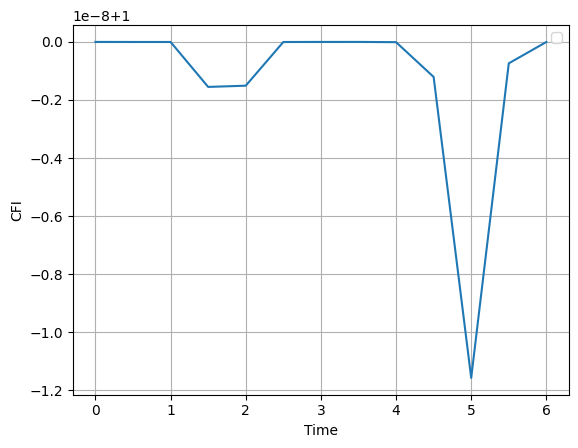

In [12]:
Sweep_data = np_.array([1e-4, np.pi * 2 + 1e-4, 5e-1])

Para_init = np_.zeros(3)
Para_init[:4] = random.uniform(0, 1)

Optimized_Result = BFGS(Sweep_data, Para_init)

plt.plot(Optimized_Result[:, 0], Optimized_Result[:, 1])
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()